In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import pymc3 as pm
from pymc3.ode import DifferentialEquation
print('Running on PyMC3 v{}'.format(pm.__version__))

from bs4 import BeautifulSoup
import requests
import re

import os

from sklearn.externals import joblib 

import pandas as pd

import theano
import scipy
floatX = theano.config.floatX

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
C:\Users\linds\Anaconda3\envs\pymc3\lib\site-packages\theano\configdefaults.py:560: UserWarning: DeprecationWarning: there is no c++ compiler.This is deprecated and with Theano 0.11 a c++ compiler will be mandatory
  warnings.warn("DeprecationWarning: there is no c++ compiler."
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC3 v3.8


C:\Users\linds\Anaconda3\envs\pymc3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
country = 'Canada'
file = os.path.join('csv_out',country+'.csv')
country_df = pd.read_csv(file)
country_df

def get_country_sir(country, start_date='', end_date='', min_cases=10):
    
    # update for any country
    # italy
    population = 60e6
    
    country = country.title().replace(' ', '_')
    file = os.path.join('csv_out',country+'.csv')
    country_df = pd.read_csv(file)
    
    start = country_df[country_df.Date == start_date].index
    if len(start)==0:
        start = 0
    else:
        start = start[0]
        
    end = country_df[country_df.Date == end_date].index
    if len(end)==0:
        end = country_df.index[-1]
    else:
        end = end[0]
        
    dates = country_df.loc[start:end + 1, 'Date'].values
    data = country_df.loc[start:end + 1, 'Confirmed'].values
    deaths = country_df.loc[start:end + 1, 'Deaths'].values
    recovered = country_df.loc[start:end+1, 'Recovered'].values

    if max(data) < min_cases:
        print('Warning, {:d} cases has not occured in this date range.')
    else:
        min_start = np.where(np.array(data) >= min_cases)[0][0]
        data = data[min_start:]
        dates = dates[min_start:]
        deaths = deaths[min_start:]
        recovered = recovered[min_start:]
        
    # infected = total cases - deaths - recoveries
    infected = data - deaths - recovered
    
    # susceptible = population - infected - deaths - recovered
    susceptible = population - infected - deaths - recovered
        
    

    return dates, np.arange(0, len(data)), susceptible/population, infected/population
    
    

In [3]:
dates, x, sus, inf = get_country_sir('italy', min_cases=100)
# sus and inf are already normalized
# just normalize x
x_train = x[:-3]
x_test = x[-3:]

scalex = MinMaxScaler()
x_scale = scalex.fit_transform(x_train.reshape(-1,1)).flatten()

sus_train = sus[:-3]
sus_test = sus[-3:]

inf_train = inf[:-3]
inf_test = inf[-3:]

# make single array
y_train = np.hstack((sus_train.reshape(-1,1), inf_train.reshape(-1,1)))
y_test = np.hstack((sus_test.reshape(-1,1), inf_test.reshape(-1,1)))

y_train.shape

y0 = [y_train[0][0], y_train[0][1]]

In [4]:
class DE(pm.ode.DifferentialEquation):
    def _simulate(self, y0, theta):
        # Initial condition comprised of state initial conditions and raveled sensitivity matrix
        s0 = np.concatenate([y0, self._sens_ic])
        
        # perform the integration
        sol = scipy.integrate.solve_ivp(
            fun = lambda t, Y: self._system(Y, t, tuple(np.concatenate([y0, theta]))),
            t_span=[self._augmented_times.min(), self._augmented_times.max()],
            y0=s0,
            method='RK23',
            t_eval=self._augmented_times[1:],
            atol=1, rtol=1,
            max_step=0.02).y.T.astype(floatX)
        
        # The solution
        y = sol[:, :self.n_states]

        # The sensitivities, reshaped to be a sequence of matrices
        sens = sol[0:, self.n_states:].reshape(self.n_times, self.n_states, self.n_p)

        return y, sens

In [5]:
def sir_function(y, t, p):
    # 'constants'
    beta = p[0] #rename to delta when testing
    lmbda = p[1]
    #beta = p[2]*pm.math.exp(-t*delta)
    
    # y = (s, i)
    
    # susceptible differential
    ds = -y[0]*y[1]*beta
    
    # infected differential
    di = y[0]*y[1]*beta - y[1]*lmbda
    
    return [ds, di]


sir_model = DE(
    func=sir_function,
    times=x_scale,
    n_states=2, # number of y (sus and inf)
    n_theta=2, # number of parameters (lambda, delta, beta_0)
    t0=0
)

In [7]:
with pm.Model() as model4:
    
    print('Initializing Priors')
    sigma = pm.HalfNormal('sigma', 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2,3)
    lmbda = pm.Normal('lambda', 0, 10)
    delta = pm.Normal('delta', 0, 10)
    beta = pm.Deterministic('beta', lmbda*R0)
    
    
    print('Setting up model')
    sir_curves = sir_model(y0=y0, theta=[beta, lmbda])#[delta, lmbda, beta])

    Y = pm.Normal('Y', mu=sir_curves, sigma=sigma, observed=y_train)

    print('Starting sampling')
    #prior = pm.sample_prior_predictive(progressbar=True)
    trace = pm.sample(2000, 
                      tune=1000, 
                      #target_accept=0.9, 
                      cores=1, 
                      progressbar=True)
    posterior_predictive = pm.sample_posterior_predictive(trace, progressbar=True)

    #data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)

Initializing Priors
Setting up model


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


Starting sampling


Sequential sampling (2 chains in 1 job)
NUTS: [delta, lambda, R0, sigma]
Sampling chain 0, 0 divergences:   1%|▍                                           | 33/3000 [17:11<25:45:49, 31.26s/it]
Only one chain was sampled, this makes it impossible to run some convergence checks
0it [00:00, ?it/s]


In [21]:
a = posterior_predictive['Y']
y0 = a[:,:,0]
y1 = a[:,:,1]

y0_mean = np.mean(y0, axis=0)
y1_mean = np.mean(y1, axis=0)

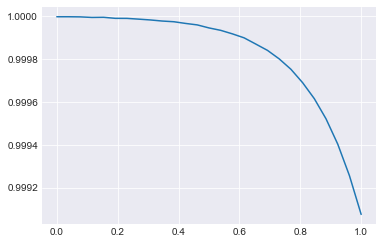

In [23]:
plt.plot(x_scale, y0_mean)
